In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [50]:
file_path = "../data/preprocessed/pokemon_preprocessed.csv"
df = pd.read_csv(file_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 52 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   abilities                  801 non-null    object 
 1   against_bug                801 non-null    float64
 2   against_dark               801 non-null    float64
 3   against_dragon             801 non-null    float64
 4   against_electric           801 non-null    float64
 5   against_fairy              801 non-null    float64
 6   against_fight              801 non-null    float64
 7   against_fire               801 non-null    float64
 8   against_flying             801 non-null    float64
 9   against_ghost              801 non-null    float64
 10  against_grass              801 non-null    float64
 11  against_ground             801 non-null    float64
 12  against_ice                801 non-null    float64
 13  against_normal             801 non-null    float64

In [51]:
df.columns

Index(['abilities', 'against_bug', 'against_dark', 'against_dragon',
       'against_electric', 'against_fairy', 'against_fight', 'against_fire',
       'against_flying', 'against_ghost', 'against_grass', 'against_ground',
       'against_ice', 'against_normal', 'against_poison', 'against_psychic',
       'against_rock', 'against_steel', 'against_water', 'attack',
       'base_egg_steps', 'base_happiness', 'base_total', 'capture_rate',
       'classfication', 'defense', 'experience_growth', 'height_m', 'hp',
       'japanese_name', 'name', 'percentage_male', 'pokedex_number',
       'sp_attack', 'sp_defense', 'speed', 'type1', 'type2', 'weight_kg',
       'generation', 'is_legendary', 'legendary_status', 'xp_growth_rate',
       'avg_damage_taken', 'max_damage_taken', 'min_damage_taken',
       'type_combo', 'offense_score', 'bulk_score', 'xp_growth_rate_from_diff',
       'difficulty_score', 'strength_difficulty_group'],
      dtype='object')

In [52]:
X_features = ["attack", "defense", "hp", "speed", "sp_attack", "sp_defense"]
df_cluster = df[X_features].copy()

In [53]:
scaler = StandardScaler()
df_cluster_scaled = pd.DataFrame(
    scaler.fit_transform(df_cluster),
    columns=X_features,
    index=df.index
)

In [54]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto")
labels = kmeans.fit_predict(df_cluster_scaled)

In [55]:
df_cluster_scaled["cluster"] = labels
df_cluster["cluster"] = labels

In [56]:
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(df_cluster_scaled[X_features])

In [57]:
centroids_2d = pca.transform(kmeans.cluster_centers_)

C:\Users\Owner\PycharmProjects\pokemon-analysis\.venv1\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


In [58]:
cluster_means_scaled = df_cluster_scaled.groupby("cluster")[X_features].mean()
cluster_means_raw = df_cluster.groupby("cluster")[X_features].mean()

In [59]:
cluster_sizes = df_cluster_scaled["cluster"].value_counts().sort_index()
cluster_sizes, cluster_means_raw, cluster_means_scaled

(cluster
 0    348
 1    227
 2    226
 Name: count, dtype: int64,
             attack    defense         hp      speed  sp_attack  sp_defense
 cluster                                                                   
 0        55.939655  52.534483  51.752874  53.181034  51.114943   50.778736
 1        99.356828  78.881057  79.127753  99.969163  99.528634   85.114537
 2        90.013274  98.637168  85.238938  52.805310  74.048673   87.646018,
            attack   defense        hp     speed  sp_attack  sp_defense
 cluster                                                               
 0       -0.681981 -0.665831 -0.647828 -0.455304  -0.624456   -0.720952
 1        0.668948  0.190970  0.382876  1.164245   0.872861    0.508618
 2        0.378223  0.833446  0.612970 -0.468309   0.084828    0.599270)

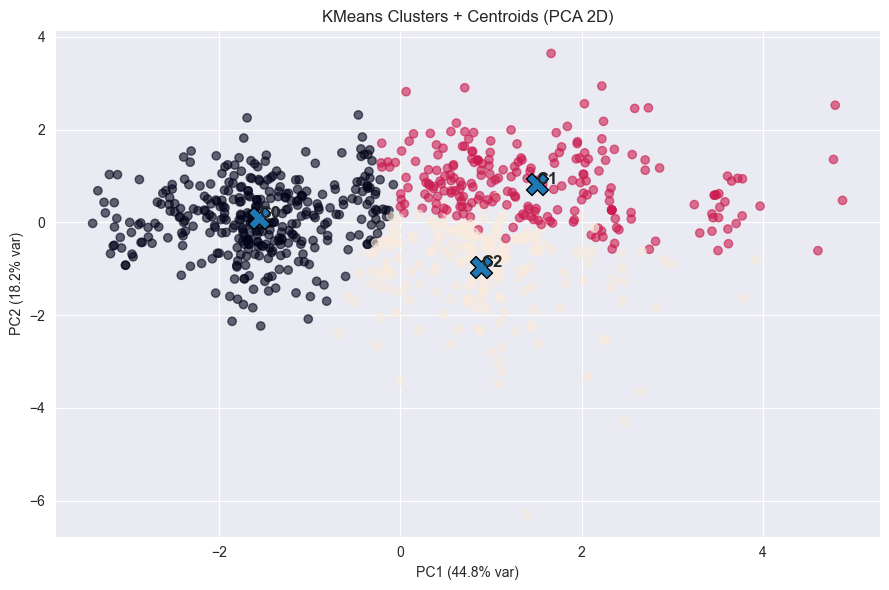

In [60]:
plt.figure(figsize=(9, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, alpha=0.6)
plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], marker="X", s=250, edgecolor="black")

for i, (x, y) in enumerate(centroids_2d):
    plt.text(x, y, f"C{i}", fontsize=12, fontweight="bold")

plt.title("KMeans Clusters + Centroids (PCA 2D)")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.tight_layout()
plt.show()

In [61]:
unique, counts = np.unique(labels, return_counts=True)
print("Cluster sizes:", dict(zip(unique, counts)))

Cluster sizes: {np.int32(0): np.int64(348), np.int32(1): np.int64(227), np.int32(2): np.int64(226)}


In [62]:
df_cluster_scaled["cluster"] = kmeans.labels_

In [63]:
cluster_kmeans = df_cluster_scaled.groupby("cluster").mean(numeric_only=True)
cluster_sizes = df_cluster_scaled["cluster"].value_counts().sort_index()

In [64]:
cluster_sizes

cluster
0    348
1    227
2    226
Name: count, dtype: int64

In [65]:
cluster_kmeans

,attack,defense,hp,speed,sp_attack,sp_defense
cluster,,,,,,
0,-0.681981,-0.665831,-0.647828,-0.455304,-0.624456,-0.720952
1,0.668948,0.190970,0.382876,1.164245,0.872861,0.508618
2,0.378223,0.833446,0.612970,-0.468309,0.084828,0.599270


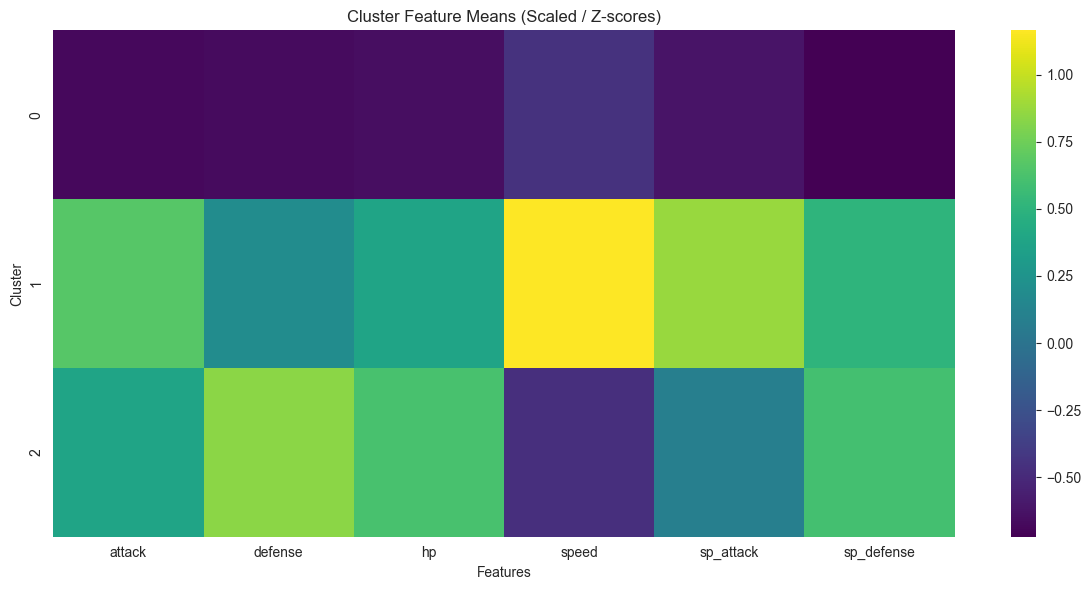

In [66]:
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_means_scaled, annot=False, cmap="viridis")
plt.title("Cluster Feature Means (Scaled / Z-scores)")
plt.xlabel("Features")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

In [67]:
global_mean = df_cluster_scaled[X_features].mean()
delta = cluster_means_scaled - global_mean

for c in delta.index:
    print(f"\nCluster {c} — strongest deviations (|z|):")
    print(delta.loc[c].abs().sort_values(ascending=False).head(6))


Cluster 0 — strongest deviations (|z|):
sp_defense    0.720952
attack        0.681981
defense       0.665831
hp            0.647828
sp_attack     0.624456
speed         0.455304
Name: 0, dtype: float64

Cluster 1 — strongest deviations (|z|):
speed         1.164245
sp_attack     0.872861
attack        0.668948
sp_defense    0.508618
hp            0.382876
defense       0.190970
Name: 1, dtype: float64

Cluster 2 — strongest deviations (|z|):
defense       0.833446
hp            0.612970
sp_defense    0.599270
speed         0.468309
attack        0.378223
sp_attack     0.084828
Name: 2, dtype: float64


In [68]:
from sklearn.metrics import silhouette_score, silhouette_samples

sil = silhouette_score(df_cluster_scaled[X_features], labels)
print("Silhouette score:", sil)

Silhouette score: 0.2597504459642978


 n_clusters = 5: Silhouette score: 0.24517326943054377
 n_clusters = 4: Silhouette score: 0.23974410723885628
 n_clusters = 3: Silhouette score: 0.2597504459642978
 n_clusters = 2: Silhouette score: 0.29038435712856603
There is no well defined cluster, which makes sense since Pokemon has a smooth progression as they evolve and many Pokemon that has 1, 2 or even 3 stages depends on the their base stage, so it's very highly correlated. We are keeping with 3 cluster.

In [69]:
examples = df[["name"]].join(df_cluster[X_features])
examples["cluster"] = labels

for c in sorted(examples["cluster"].unique()):
    print(f"\nCluster {c} examples:")
    print(examples[examples["cluster"] == c][["name"] + X_features].head(8).to_string(index=False))


Cluster 0 examples:
      name  attack  defense  hp  speed  sp_attack  sp_defense
 Bulbasaur      49       49  45     45         65          65
   Ivysaur      62       63  60     60         80          80
Charmander      52       43  39     65         60          50
Charmeleon      64       58  58     80         80          65
  Squirtle      48       65  44     43         50          64
 Wartortle      63       80  59     58         65          80
  Caterpie      30       35  45     45         20          20
   Metapod      20       55  50     30         25          25

Cluster 1 examples:
     name  attack  defense  hp  speed  sp_attack  sp_defense
 Venusaur     100      123  80     80        122         120
Charizard     104       78  78    100        159         115
Blastoise     103      120  79     78        135         115
 Beedrill     150       40  65    145         15          80
  Pidgeot      80       80  83    121        135          80
   Fearow      90       65  65    

C:\Users\Owner\PycharmProjects\pokemon-analysis\.venv1\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


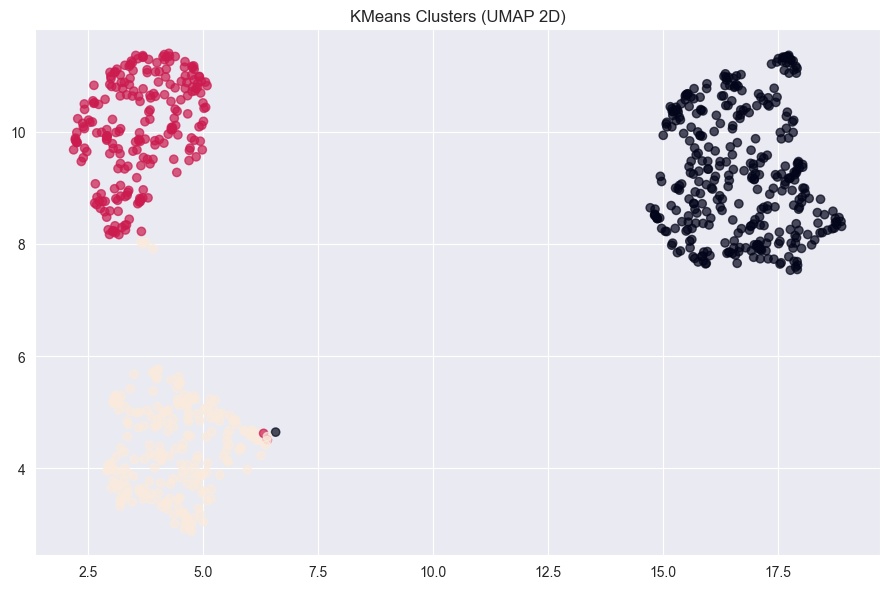

In [70]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

reducer = umap.UMAP(n_neighbors=20, min_dist=0.1, random_state=42)
X_umap = reducer.fit_transform(df_cluster_scaled)

plt.figure(figsize=(9, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=labels, alpha=0.7)
plt.title("KMeans Clusters (UMAP 2D)")
plt.tight_layout()
plt.show()

Let's look now at how the clustering looks like with the aggregate features

In [71]:
X1_features = ["offense_score", "bulk_score", "difficulty_score", "avg_damage_taken", "base_total"]
df_cluster1 = df[X1_features].copy()

In [72]:
df_cluster_scaled1 = pd.DataFrame(
    scaler.fit_transform(df_cluster1),
    columns=X1_features,
    index=df.index
)

In [73]:
kmeans1 = KMeans(n_clusters=3, random_state=42, n_init="auto")
labels1 = kmeans1.fit_predict(df_cluster_scaled1)
X_2d1 = pca.fit_transform(df_cluster_scaled1[X1_features])

In [74]:
df_cluster_scaled1["cluster"] = labels1
df_cluster1["cluster"] = labels1
X_2d1 = pca.fit_transform(df_cluster_scaled1[X1_features])

In [75]:
cluster_means_scaled1 = df_cluster_scaled1.groupby("cluster")[X1_features].mean()
cluster_means_raw1 = df_cluster1.groupby("cluster")[X1_features].mean()

In [76]:
cluster_sizes = df_cluster_scaled1["cluster"].value_counts().sort_index()
cluster_sizes, cluster_means_raw1, cluster_means_scaled1

(cluster
 0    401
 1    101
 2    299
 Name: count, dtype: int64,
          offense_score  bulk_score  difficulty_score  avg_damage_taken  \
 cluster                                                                  
 0            78.162095   79.764755          0.094781          1.063452   
 1           109.577558   98.422442          1.455351          1.049917   
 2            50.594203   49.874025         -0.618722          1.053419   
 
          base_total  
 cluster              
 0        473.780549  
 1        624.000000  
 2        301.404682  ,
          offense_score  bulk_score  difficulty_score  avg_damage_taken  \
 cluster                                                                  
 0             0.264512    0.404009          0.115132          0.051534   
 1             1.577399    1.260086          1.767829         -0.076402   
 2            -0.887580   -0.967479         -0.751567         -0.043306   
 
          base_total  
 cluster              
 0          0.381

In [77]:
centroids_2d1 = pca.transform(kmeans1.cluster_centers_)

C:\Users\Owner\PycharmProjects\pokemon-analysis\.venv1\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


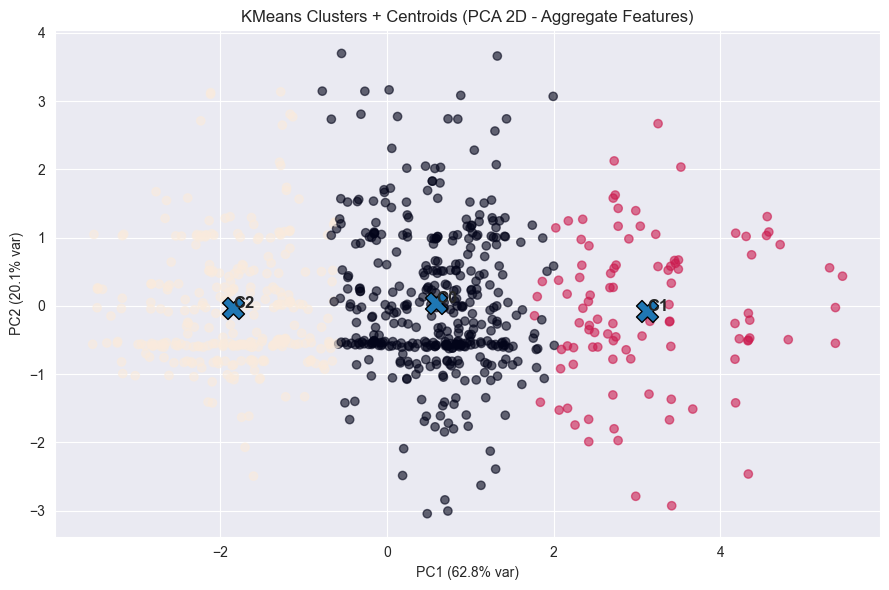

In [78]:
plt.figure(figsize=(9, 6))
plt.scatter(X_2d1[:, 0], X_2d1[:, 1], c=labels1, alpha=0.6)
plt.scatter(centroids_2d1[:, 0], centroids_2d1[:, 1], marker="X", s=250, edgecolor="black")

for i, (x, y) in enumerate(centroids_2d1):
    plt.text(x, y, f"C{i}", fontsize=12, fontweight="bold")

plt.title("KMeans Clusters + Centroids (PCA 2D - Aggregate Features)")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.tight_layout()
plt.show()

In [79]:
unique, counts = np.unique(labels1, return_counts=True)
print("Cluster sizes:", dict(zip(unique, counts)))

Cluster sizes: {np.int32(0): np.int64(401), np.int32(1): np.int64(101), np.int32(2): np.int64(299)}


In [80]:
cluster_kmeans = df_cluster_scaled1.groupby("cluster").mean(numeric_only=True)
cluster_sizes = df_cluster_scaled1["cluster"].value_counts().sort_index()

In [81]:
cluster_kmeans

,offense_score,bulk_score,difficulty_score,avg_damage_taken,base_total
cluster,,,,,
0,0.264512,0.404009,0.115132,0.051534,0.381129
1,1.577399,1.260086,1.767829,-0.076402,1.642108
2,-0.887580,-0.967479,-0.751567,-0.043306,-1.065838


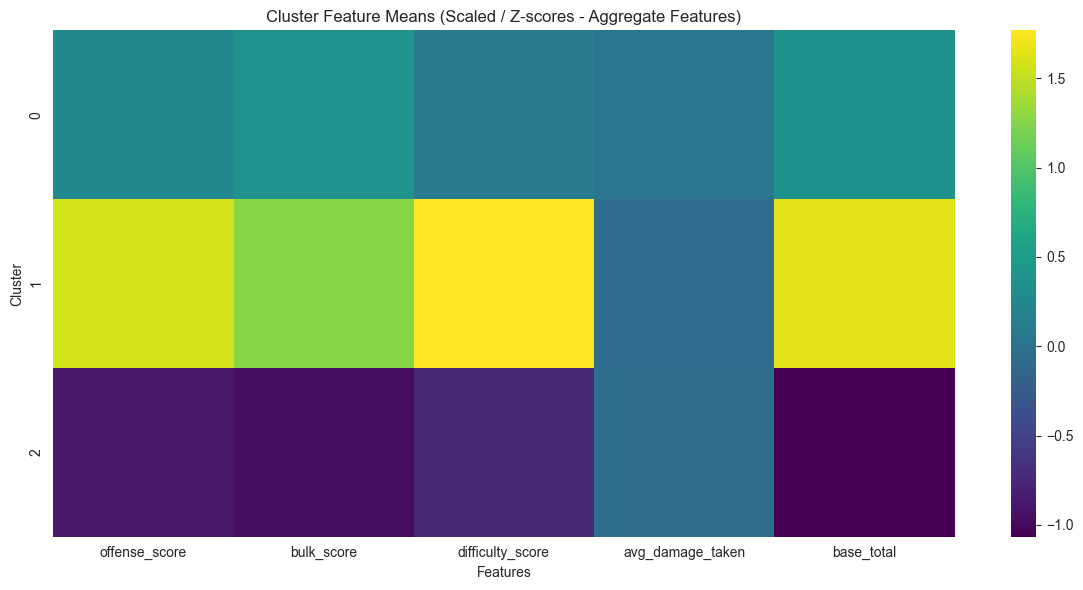

In [82]:
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_means_scaled1, annot=False, cmap="viridis")
plt.title("Cluster Feature Means (Scaled / Z-scores - Aggregate Features)")
plt.xlabel("Features")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

In [83]:
global_mean = df_cluster_scaled1[X1_features].mean()
delta1 = cluster_means_scaled1 - global_mean

for c in delta1.index:
    print(f"\nCluster {c} — strongest deviations (|z|):")
    print(delta1.loc[c].abs().sort_values(ascending=False).head(6))


Cluster 0 — strongest deviations (|z|):
bulk_score          0.404009
base_total          0.381129
offense_score       0.264512
difficulty_score    0.115132
avg_damage_taken    0.051534
Name: 0, dtype: float64

Cluster 1 — strongest deviations (|z|):
difficulty_score    1.767829
base_total          1.642108
offense_score       1.577399
bulk_score          1.260086
avg_damage_taken    0.076402
Name: 1, dtype: float64

Cluster 2 — strongest deviations (|z|):
base_total          1.065838
bulk_score          0.967479
offense_score       0.887580
difficulty_score    0.751567
avg_damage_taken    0.043306
Name: 2, dtype: float64


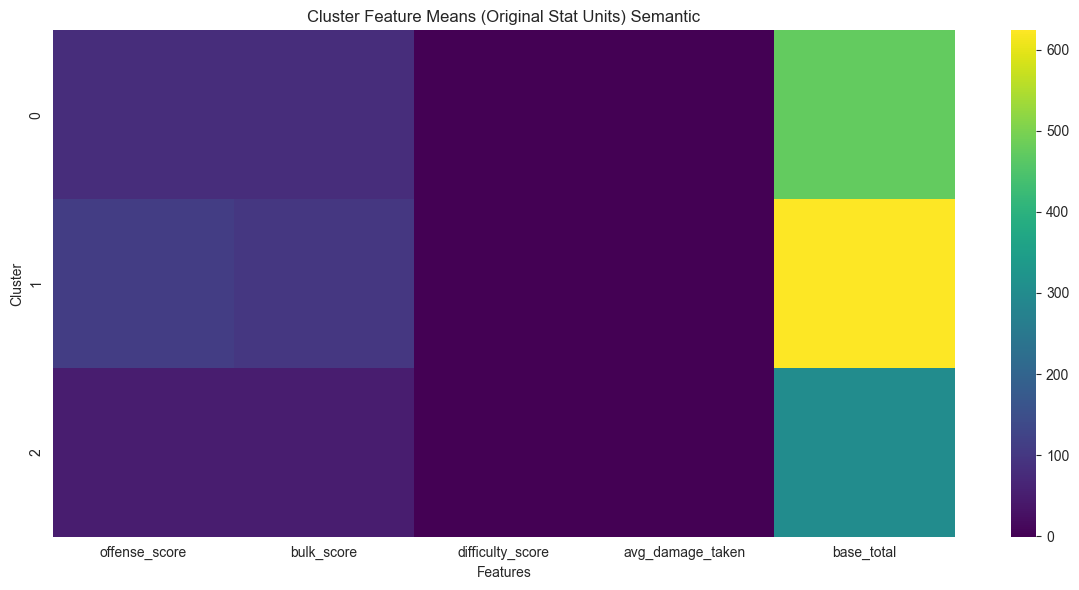

In [84]:
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_means_raw1, annot=False, cmap="viridis")
plt.title("Cluster Feature Means (Original Stat Units) Semantic")
plt.xlabel("Features")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

In [85]:
sil = silhouette_score(df_cluster_scaled1[X1_features], labels1)
print("Silhouette score:", sil)

Silhouette score: 0.3398027335392512


In [86]:
examples = df[["name"]].join(df_cluster1[X1_features])
examples["cluster"] = labels1

for c in sorted(examples["cluster"].unique()):
    print(f"\nCluster {c} examples:")
    print(examples[examples["cluster"] == c][["name"] + X1_features].head(8).to_string(index=False))


Cluster 0 examples:
      name  offense_score  bulk_score  difficulty_score  avg_damage_taken  base_total
   Ivysaur      67.333333   67.666667          0.194202          1.069444         405
Charmeleon      74.666667   60.333333          0.194202          1.000000         405
 Wartortle      62.000000   73.000000          0.194202          1.000000         405
Butterfree      68.333333   63.333333          0.096554          1.222222         395
  Beedrill     103.333333   61.666667          0.096554          1.055556         495
   Pidgeot     112.000000   81.000000          0.096554          1.000000         579
  Raticate      62.666667   75.000000         -0.441495          1.000000         413
    Fearow      83.666667   63.666667         -0.198717          1.000000         442

Cluster 1 examples:
      name  offense_score  bulk_score  difficulty_score  avg_damage_taken  base_total
  Venusaur     100.666667  107.666667          0.194202          1.069444         625
 Charizard  

C:\Users\Owner\PycharmProjects\pokemon-analysis\.venv1\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


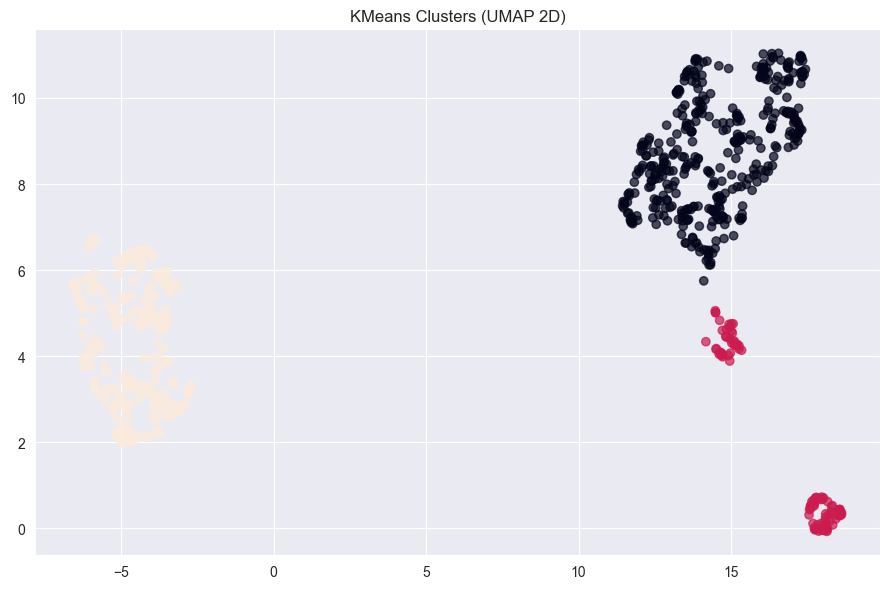

In [87]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

reducer = umap.UMAP(n_neighbors=20, min_dist=0.1, random_state=42)
X_umap = reducer.fit_transform(df_cluster_scaled1)

plt.figure(figsize=(9, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=labels1, alpha=0.7)
plt.title("KMeans Clusters (UMAP 2D)")
plt.tight_layout()
plt.show()

In [88]:
cluster_names = {
    0: "Balanced Core",
    1: "Elite / Powerhouses",
    2: "Low-Impact / Early-Game"
}

In [89]:
df["cluster"] = labels1
df["cluster_name"] = df["cluster"].map(cluster_names)

In [90]:
legendary_by_cluster = (
    df.groupby("cluster_name")["is_legendary"]
    .agg(["count", "sum", "mean"])
    .rename(columns={
        "count": "total_pokemon",
        "sum": "legendary_count",
        "mean": "legendary_ratio"
    })
)

In [91]:
legendary_by_cluster["legendary_pct"] = legendary_by_cluster["legendary_ratio"] * 100
legendary_by_cluster

,total_pokemon,legendary_count,legendary_ratio,legendary_pct
cluster_name,,,,
Balanced Core,401,4,0.009975,0.997506
Elite / Powerhouses,101,65,0.643564,64.356436
Low-Impact / Early-Game,299,1,0.003344,0.334448


C:\Users\Owner\AppData\Local\Temp\ipykernel_12040\1860378436.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


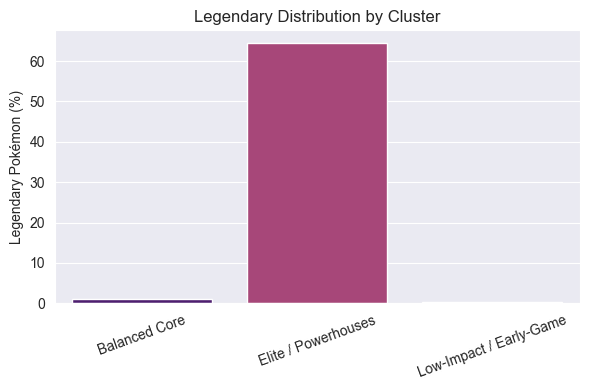

In [92]:
plt.figure(figsize=(6, 4))
sns.barplot(
    data=legendary_by_cluster.reset_index(),
    x="cluster_name",
    y="legendary_pct",
    palette="magma"
)
plt.ylabel("Legendary Pokémon (%)")
plt.xlabel("")
plt.title("Legendary Distribution by Cluster")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

In [93]:
type_dist = (
    df.groupby(["cluster_name", "type1"])
    .size()
    .reset_index(name="count")
)

In [94]:
type_dist["pct"] = (
        type_dist["count"] /
        type_dist.groupby("cluster_name")["count"].transform("sum") * 100
)

In [95]:
top_types = (
    type_dist.sort_values("pct", ascending=False)
    .groupby("cluster_name")
    .head(6)
)

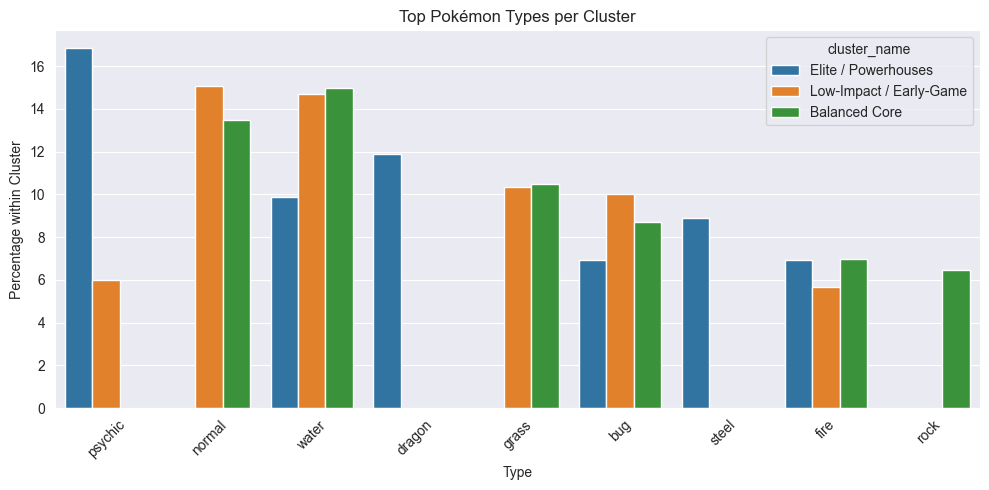

In [96]:
plt.figure(figsize=(10, 5))
sns.barplot(
    data=top_types,
    x="type1",
    y="pct",
    hue="cluster_name"
)
plt.ylabel("Percentage within Cluster")
plt.xlabel("Type")
plt.title("Top Pokémon Types per Cluster")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Cluster Summary

- Cluster 0: 101 Pokemon - "Elite / Powerhouse"

This cluster contains all the Pokemon that have an average 624 base total stats, with high offense (1.58), defensive (1.26), and hard to capture (1.77), it is mostly constituted of fully evolved Pokemon and also where the majority of the legendary Pokemon are located.

- Cluster 1: 401 Pokemon - "Balanced Core"

- This cluster has an average of 474 base total stats, where the Bulk stat is slightly above average (Z-score +0.4), offense is balanced (0.26) and the capture difficulty is average. Most the Pokemon in this clusters are either early/mid stage evolutions. Overall, they are all well-rounded and have flexible roles, which makes sense.

- Cluster 1: 299 Pokemon - "Early Game"

- This cluster have the lowest overall stats, with base total on average 301, offense, bulk, and difficulty much closer to -1. They are not necessary "bad" Pokemon, but they are not competitive and should not be used against gym leaders, for example. But great Pokemon in the early game.

As expected, the Psychic and Dragon Pokemon type contains the most elite pokemon, mostly due to their vulnerabilities and strong moves. Normal, Water, Grass and Fire type are mostly balanced pokemon while, bug and normal types are better early game.